# Pop and Country Songs Audio Features Analysis:

### Background:

The songs that we hear around these days, it is hard to distinguish a country song from a pop song, but is there really a difference between the two?  Are there song features which will be able to classify these two genres?



<br>For this project, __we will analyzing Pop and country songs from 1990 onwards__, and we will be extracting Spotify Features via the Spotify API, where the following data will be used:

[Spotify Audio Features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)
- __acousticness__: describes how many acoustic sounds the track has vs. how many electric sounds [0.0 to 1.0] 
- __danceability__: describes how suitable a track is for dancing based on a combination of musical elements.
  [0.0 least danceable to 1.0 most danceable)
- duration_ms
- __energy__: represents perceptual measure of intensity and activity.  typically energetic feels fast, loud and noisy.
  [0.0 to 1.0]
- instrumentalness
- key
- liveness
- loudness
- mode
- speechiness
- tempo
- time signature
- __valence__: measure from [0.0 to 1.0] describes the musical positiveness conveyed by a track.  Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

[Spotify Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)
- bar length: a bar or measure is a segment of time as a given number of beats
- beats length: The time interval of beats throughout the track.  A beat is the basic time unit of a piece of music.
- sections length: defined by large ariation in rhythm or timbre e.g. chorus, verse, bridge, guitar solo etc.
- segment length:  each segment contains a roughly consistent sound throughout its duration
  * average & __median pitch__ - values from 0 to 1 that describe the relative dominance of every pitch in the scale.
  * average & __median timbre__ - timbre is the quality of musical note or sound that distinguishes different types of 
    musical instruments or voices.


We will be analyzing songs which have been tagged with the word 'pop' or 'country' from the Million Songs Database https://labrosa.ee.columbia.edu/millionsong/.

and in the end specifically explore if there are differences between Taylor Swift's pre-pop - country songs and her pop songs.


### Problem Definition:

- How does country and pop music differ?  
- Are there differences between the two music genres? -- Can we find some patterns that would differentiate these two music genres? 
- What patterns do we find with the song features?






### Limitations

- since we are relying on the tags from the Million Songs Database to filter out pop and country songs, we can potentially have a 'noisy' data, since we could have jazz, rock songs, or songs with other genres which were added with incorrect tags.  But we should be able to see all these when we try to create clusters for our songs.  


- Due to time constraints for this project, the analysis will just be done on Song Features from Spotify, and Lyrics analysis will be done as a future project.


 



### Acquiring Data Set:

Data sets were acquired from the different Sources:

(1) To get the list of Artists, Songs, and genre tags records were extracted from the Million Song Database

 [Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. 
The Million Song Dataset. In Proceedings of the 12th International Society
for Music Information Retrieval Conference (ISMIR 2011), 2011.](https://labrosa.ee.columbia.edu/millionsong/)

<br>(2) To get audio features of the songs, Spotify API was used, given
the artist name, and song title, the spotify Track ID can be retrieved, which can then be used to query the audio features for the song. [Code](https://github.com/ayeshavm/SongFeatures_Unsupervised/blob/master/source/getSpotifyAudioFeatures.py)


(3) To get the lyrics of the songs, the Genius API will be used, to search the song based on a given Artist Name, and song title. [code](https://github.com/ayeshavm/SongFeatures_Unsupervised/blob/master/source/getGeniusLyrics.py).
Code was adapted [from](https://github.com/johnwmillr/LyricsGenius)




### Cleaning The Data and Feature Engineering:

1) Combine the song data collected from Spotify with the Spotify Features, and the Lyrics collected from Genius.
   Only keep records with both Spotify Features, and Lyrics Text from Genius.
   
   
2) The Spotify Features extracted were in JSON format.  Reformatted records to create a column for every Spotify Feature attribute.

3) Added a column 'genre' which was derived based on the tags found from the Song record.  A song was classified as 'pop' if 'pop' occurred in the tag the most, 'country' if 'country' occurred in the tag the most, otherwise, it will be tagged as 'other'.  This column will only be used for verifying output, but cannot provide a good score of accuracy since songs can be mis-tagged.  i.e. Beyonce's song records are tagged with 'country' instead of 'pop'.

4) Lyrics Text were initially cleaned using nlp Language detector to remove tags, i.e. [Verses], [Chorus]. And used to filter out to only work with songs where Language == English.

5)[Flesch-Kincaid Grade](https://en.wikipedia.org/wiki/Flesch–Kincaid_readability_tests) was derived from the Lyrics, but this feature did not show to be helpful in creating more distinct features, so was excluded in the final analysis.

5) Additional data cleansing was done to filter out the noise from the mislabeled data from the Million Songs Database.  Genre tags were extracted from Spotify to update the genre labels of the songs, and filter out songs which are not labeled as country or pop.  The number of songs went down from 17001+ to 5881+.





In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 2000

In [3]:
### read in files with updated Spotify Features

In [89]:
df1 = pd.read_pickle('../data/spotify_1118_bkp.p')
df2 = pd.read_pickle('../data/spotify_1119_bkp.p')

In [90]:
df1 = df1[:18200].copy()
df2 = df2[18200:18382].copy()

In [91]:
songsDF = pd.DataFrame(data=None, columns=df1.columns)
songsDF = df1.append(df2, ignore_index=True)

In [92]:
len(songsDF)

18382

In [93]:
songsDF.head()

level_0  index           artist_id  \
0        0    0.0  AR009211187B989185   
1        1    1.0  AR00FOZ1187FB5C9F3   
2        4    4.0  AR00FOZ1187FB5C9F3   
3        6    6.0  AR00FOZ1187FB5C9F3   
4        7    7.0  AR00FOZ1187FB5C9F3   

                                                tags            track_id  \
0  [(pop rock,), (pop,), (synthpop,), (reggae pop,)]  TRDBNUI128F933DE6E   
1                [(synthpop,), (pop,), (pukkelpop,)]  TRWTSUW12903CD2DEA   
2                [(synthpop,), (pop,), (pukkelpop,)]  TRTMPTG128F92F00A0   
3                [(synthpop,), (pop,), (pukkelpop,)]  TREUZLW128F933D2B5   
4                [(synthpop,), (pop,), (pukkelpop,)]  TRJAWFF128F933B4C1   

                               title             song_id  \
0                       I'm So Sorry  SOZCBYK12AB0180B4D   
1                      Stay The Same  SOBGFYV12AB018DEAD   
2                        Always More  SOUQQXB12A8C140687   
3               Stay the Same (Edit)  SOIPHDN12A58A7A4A4   
4  Stay the Same (Alex Gopher Remix)  SOTGYBS12AB0181095   

                                             release  \
0  The Best Of Original British Lovers Rock Volum...   
1                                      Stay The Same   
2                                             Animal   
3                       Kitsuné Maison Compilation 6   
4                                     My New Remixes   

                            artist_mbid       artist_name   duration  \
0  9dfe78a6-6d91-454e-9b95-9d7722cbc476  Carroll Thompson  260.91057   
1  92337972-f0c5-4ebd-be8c-f6b23d596ae1         autoKratz  404.97587   
2  92337972-f0c5-4ebd-be8c-f6b23d596ae1         autoKratz  255.26812   
3  92337972-f0c5-4ebd-be8c-f6b23d596ae1         autoKratz  227.47383   
4  92337972-f0c5-4ebd-be8c-f6b23d596ae1         autoKratz  311.79710   

   artist_familiarity  artist_hotttnesss  year track_7digitalid shs_perf  \
0            0.396818           0.297405  2007          6144722       -1   
1            0.632410           0.499475  2008          6548152       -1   
2            0.632410           0.499475  2009          5334937       -1   
3            0.632410           0.499475  2008          4708936       -1   
4            0.632410           0.499475  2009          7088638       -1   

  shs_work                                        lyrics_text  \
0        0  Gabrielle\nGabrielle\nI'm So Glad\nI can never...   
1        0  We can't always stay the same, but we all keep...   
2        0  Faith I'm sure, there's something wanting but ...   
3        0  We can't always stay the same, but we all keep...   
4        0  We can't always stay the same, but we all keep...   

               spotifyURI                                       songFeatures  \
0  4EPZgfbYO1gjE7LeiNBLtx  [{'danceability': 0.862, 'energy': 0.34, 'key'...   
1  1gZ4TP1pQwRD5WhYKDG0jw  [{'danceability': 0.602, 'energy': 0.733, 'key...   
2  6PWoHhgOdh2gAn0FUAdbff  [{'danceability': 0.596, 'energy': 0.976, 'key...   
3  16OdcyESbiNw4ggB7PkdZP  [{'danceability': 0.713, 'energy': 0.87, 'key'...   
4  6bLQjT2IvQfu5ZLfcXuBa5  [{'danceability': 0.649, 'energy': 0.709, 'key...   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.803   0.994   0.0    -4.202   1.0       0.1740      0.004290   
1         0.641   0.801   7.0    -4.179   0.0       0.0302      0.002870   
2         0.602   0.733   4.0    -4.019   0.0       0.3600      0.000056   
3         0.713   0.870  10.0    -4.328   0.0       0.0940      0.017800   
4         0.649   0.709  11.0    -7.638   0.0       0.0809      0.008690   

   instrumentalness  liveness  valence    tempo            type  \
0          0.463000    0.0432   0.0384  141.081  audio_features   
1          0.002620    0.0716   0.9160  127.000  audio_features   
2          0.000032    0.2270   0.4720  129.943  audio_features   
3          0.029600    0.2250   0.7230  132.019  audio_features   
4          0.082200    0.0505   0.4190  123.992

In [95]:
#songsDF.drop_duplicates(subset=['artist_id', 'title', 'song_id'], inplace=True)

In [96]:
nullidx = songsDF.index[songsDF['bar_len'].isnull()]

In [97]:
songsDF.drop(nullidx, inplace=True)

In [98]:
len(songsDF)

17007

In [99]:
#backup a copy of all song Feature Data
songsDF.to_pickle('../data/SongsSpotifyFeaturesAll.p')

### Exploring Spotify Audio Track Features 

In [100]:
songsDF.describe().T

count           mean           std          min  \
level_0             17007.0   10667.069383   5839.114159     0.000000   
index               17007.0    6127.681896   3555.215410     0.000000   
duration            17007.0     234.006487     80.204332     0.313020   
artist_familiarity  17007.0       0.660043      0.105929     0.000000   
artist_hotttnesss   17007.0       0.462639      0.094549     0.000000   
danceability        17007.0       0.513957      0.157236     0.000000   
energy              17007.0       0.616756      0.255423     0.000020   
key                 17007.0       5.174987      3.536966     0.000000   
loudness            17007.0      -8.428815      4.006588   -41.202000   
mode                17007.0       0.733933      0.441913     0.000000   
speechiness         17007.0       0.061527      0.069893     0.000000   
acousticness        17007.0       0.296223      0.328668     0.000000   
instrumentalness    17007.0       0.092479      0.224250     0.000000   
liveness            17007.0       0.192396      0.157008     0.000000   
valence             17007.0       0.465892      0.245190     0.000000   
tempo               17007.0     122.601933     29.749411     0.000000   
duration_ms         17007.0  232655.973305  82443.777310  5293.000000   
time_signature      17007.0       3.877521      0.427220     0.000000   
country_count       17007.0       1.276357      1.783586     0.000000   
pop_count           17007.0       1.143647      1.803894     0.000000   
other_count         17007.0       0.000000      0.000000     0.000000   
FKRG1               17007.0      66.630350      9.185595    49.270000   
fkrg_sent1          17007.0       1.000000      0.000000     1.000000   
FKRG2               17007.0       5.933527      8.391058    -9.320000   
fkrg_sent2          17007.0      24.178515     14.096036     1.000000   
bar_len             17007.0     120.805433     53.164340     0.000000   
beat_len            17007.0     466.950903    193.079612     0.000000   
seg_len             17007.0     789.578703    285.980223    14.000000   
pitch_mean          17007.0       0.340408      0.064808     0.149327   
pitch_med           17007.0       0.220255      0.088872     0.013500   
timbre_mean         17007.0       3.273707      5.675544   -22.434789   
timbre_med          17007.0      -0.059834      3.472851   -13.276000   

                              25%            50%            75%           max  
level_0               5697.500000   10936.000000   15698.500000  2.041200e+04  
index                 3033.500000    6164.000000    9054.000000  1.297000e+04  
duration               188.930160     226.350570     266.226485  2.144444e+03  
artist_familiarity       0.591784       0.652092       0.728730  9.473275e-01  
artist_hotttnesss        0.397528       0.452215       0.515471  8.492910e-01  
danceability             0.409000       0.521000       0.623000  9.800000e-01  
energy                   0.418000       0.648000       0.842000  1.000000e+00  
key                      2.000000       5.000000       8.000000  1.100000e+01  
loudness               -10.728500      -7.656000      -5.409000  2.132000e+00  
mode                     0.000000       1.000000       1.000000  1.000000e+00  
speechiness              0.031200       0.038500       0.059100  9.560000e-01  
acousticness             0.008860       0.137000       0.572000  9.960000e-01  
instrumentalness         0.000001       0.000169       0.019200  1.000000e+00  
liveness                 0.098800       0.128000       0.242000  9.990000e-01  
valence                  0.263000       0.446000       0.656000  9.860000e-01  
tempo                   99.995000     120.259000     141.176500  2.434950e+02  
duration_ms         188213.500000  226080.000000  265347.000000  2.144453e+06  
time_signature           4.000000       4.000000       4.000000  5.000000e+00  
country_count            0.000000       1.000000       2.000000  1.300000e+01  
pop_count   

Filter out songs with the cleaned out genres from Spotify

In [101]:
spGenre = pd.read_pickle('../data/SpotifyArtistGenre_done.p')
spGenre.head()

artist_id       artist_name                     title  \
0  AR009211187B989185  Carroll Thompson              I'm So Sorry   
1  AR00FOZ1187FB5C9F3         autoKratz             Stay The Same   
2  AR00TGQ1187B994F29      Paula Toller                  All Over   
3  AR00Y9I1187B999412         Akercocke  Praise The Name Of Satan   
4  AR01SCU1187B9A693C       Street Dogs                Savin Hill   

  SpotifyGenre  country_count  pop_count  other_count         spotifyArtistID  
0        other            0.0        0.0          2.0  1YN1OuUFRoFlnwR97pIRlJ  
1        other            0.0        0.0          2.0  47cwlbmfcqKZQsisqRfQz8  
2        other            0.0        0.0          1.0  5BQveHScm6btG6jfbxwyfs  
3        other            0.0        0.0          9.0  0YAOC9q7XHpKplKYf7FMSp  
4        other            0.0        0.0          6.0  0spqoVkfVzRyAPmA6ZY5F9

In [102]:
popcntry_Artist = spGenre[(spGenre.SpotifyGenre.isin(['pop','country']))]

In [103]:
songsDF.columns

Index(['level_0', 'index', 'artist_id', 'tags', 'track_id', 'title', 'song_id',
       'release', 'artist_mbid', 'artist_name', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'year', 'track_7digitalid',
       'shs_perf', 'shs_work', 'lyrics_text', 'spotifyURI', 'songFeatures',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'country_count', 'pop_count', 'other_count',
       'language', 'lyrics_clean', 'FKRG1', 'fkrg_sent1', 'FKRG2',
       'fkrg_sent2', 'bar_len', 'beat_len', 'seg_len', 'pitch_mean',
       'pitch_med', 'timbre_mean', 'timbre_med'],
      dtype='object')

In [104]:
#reprocessing Spotify features need to drop previously populated columns
newDF = songsDF.drop(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature','genre', 'country_count', 'pop_count', 'other_count'], axis=1).copy()

In [105]:
genre_dict = popcntry_Artist.set_index('artist_id').T.to_dict('list')

In [106]:
genre_dict['AR028WW1187FB3C9B4'][2]

'pop'

In [107]:
newDF.reset_index(drop=True, inplace=True)

In [108]:
genre_idx = 2
cntry_idx = 3
pop_idx = 4
other_idx = 5

for i, row in enumerate(newDF.itertuples(), start=0):
     
     
    #search for artist_id in genre_dict, if not found mark as delete
    if row.artist_id in genre_dict:
        newDF.set_value(i,'genre',genre_dict[row.artist_id][genre_idx])
        newDF.set_value(i,'country_cnt',genre_dict[row.artist_id][cntry_idx])
        newDF.set_value(i,'pop_cnt',genre_dict[row.artist_id][pop_idx])
        newDF.set_value(i,'other_cnt',genre_dict[row.artist_id][other_idx])
        newDF.set_value(i,'drop_row',0)
    else:
        newDF.set_value(i,'drop_row',1)


In [109]:
len(newDF[newDF.drop_row == 0])

5882

In [110]:
newDF = newDF[newDF.drop_row == 0].copy()

In [111]:
len(newDF)

5882

Format Spotify Features and add columns to DataFrame

In [112]:
newDF.reset_index(drop=True,inplace=True)

In [113]:
for i, row in enumerate(newDF.itertuples(),start=0):
    features = row.songFeatures[0]
    
    #save features as individual column names
    try:
        for key, value in features.items():
            newDF.set_value(i, key, value)
    except:
        print('error processing features for row {}'.format(i))

error processing features for row 933


In [114]:
nullidx = newDF.index[newDF.liveness.isnull()]

newDF.drop(nullidx, axis=0, inplace=True)

In [115]:
newDF.reset_index(drop=True,inplace=True)
len(newDF)

5881

In [117]:
#Add another field to categorize year of the songs into a range
newDF.year.value_counts()

2007    656
2005    627
2006    562
2008    541
2009    533
2003    512
2002    478
2004    472
2001    445
1992    230
1994    207
1991    206
1993    176
1990    121
2010    115
Name: year, dtype: int64

In [118]:
def getYearCat(row):
    ''' returns Year category for the song 1990-1995, 2000-2005, 2005-2010'''
    if (row['year'] >=1990) & (row['year'] <=1995):
        return '1990-1995'
    elif (row['year'] >=2000) & (row['year'] <=2005):
        return '2000-2005'
    elif (row['year'] >=2006) & (row['year'] <=2010):
        return '2006-2010'
    
newDF['songYear'] = songsDF.apply(lambda x: getYearCat(x), 1)

In [119]:
newDF.columns

Index(['level_0', 'index', 'artist_id', 'tags', 'track_id', 'title', 'song_id',
       'release', 'artist_mbid', 'artist_name', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'year', 'track_7digitalid',
       'shs_perf', 'shs_work', 'lyrics_text', 'spotifyURI', 'songFeatures',
       'language', 'lyrics_clean', 'FKRG1', 'fkrg_sent1', 'FKRG2',
       'fkrg_sent2', 'bar_len', 'beat_len', 'seg_len', 'pitch_mean',
       'pitch_med', 'timbre_mean', 'timbre_med', 'drop_row', 'genre',
       'country_cnt', 'pop_cnt', 'other_cnt', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'songYear'],
      dtype='object')

In [123]:
### save final cleaned file as pickle file

newDF.to_pickle('../data/Songs_input_1128.p')

## Visualizing and Exploring Features



In [3]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
#songsDF = pd.read_pickle('../data/Songs_input.p')
songsDF = pd.read_pickle('../data/Songs_input_1128.p')

In [5]:
songsDF.columns

Index(['level_0', 'index', 'artist_id', 'tags', 'track_id', 'title', 'song_id',
       'release', 'artist_mbid', 'artist_name', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'year', 'track_7digitalid',
       'shs_perf', 'shs_work', 'lyrics_text', 'spotifyURI', 'songFeatures',
       'language', 'lyrics_clean', 'FKRG1', 'fkrg_sent1', 'FKRG2',
       'fkrg_sent2', 'bar_len', 'beat_len', 'seg_len', 'pitch_mean',
       'pitch_med', 'timbre_mean', 'timbre_med', 'drop_row', 'genre',
       'country_cnt', 'pop_cnt', 'other_cnt', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'songYear'],
      dtype='object')

In [6]:
len(songsDF)

5881

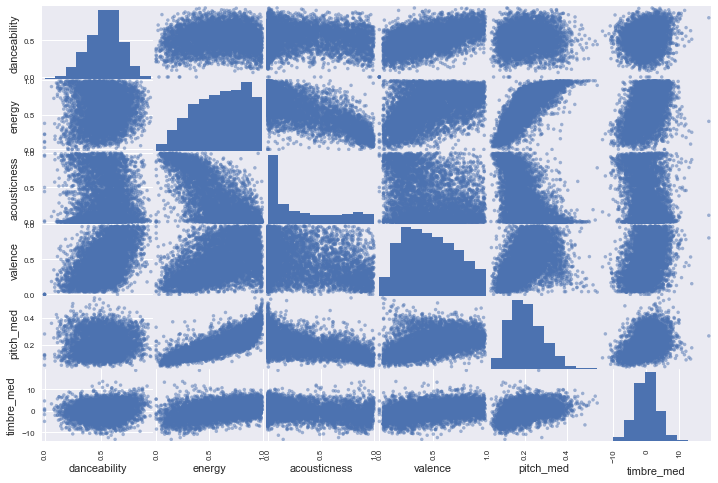

In [7]:
from pandas.plotting import scatter_matrix


features = ['danceability', 'energy', 'acousticness', 'valence', 'pitch_med',  'timbre_med']

scatter_matrix(songsDF[features], figsize=(12, 8))

plt.savefig('../images/features_scatter_matrix.png')

#### Some of the relationships between features we will find from this plot are:
- pitch+timbre - positive correlation
- valence+danceability - positive correlation
- energy+acousticness - negative correlation (high energy - low acoustic)
- energy+pitch - positive correlation

In [8]:
corr_matrix = songsDF[features].corr()

In [9]:
corr_matrix

danceability    energy  acousticness   valence  pitch_med  \
danceability      1.000000  0.056624     -0.058779  0.495712   0.051807   
energy            0.056624  1.000000     -0.750568  0.452442   0.790793   
acousticness     -0.058779 -0.750568      1.000000 -0.316676  -0.549708   
valence           0.495712  0.452442     -0.316676  1.000000   0.429611   
pitch_med         0.051807  0.790793     -0.549708  0.429611   1.000000   
timbre_med        0.149024  0.386414     -0.267652  0.334961   0.375089   

              timbre_med  
danceability    0.149024  
energy          0.386414  
acousticness   -0.267652  
valence         0.334961  
pitch_med       0.375089  
timbre_med      1.000000

#### If we plot some of these features for songs which have been tagged as 'country' or 'pop', we can notice a large overlap of values for both pop and country songs.

In [10]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

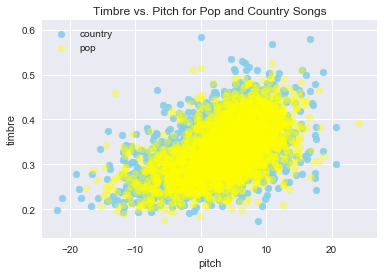

In [11]:
plt.scatter(country['timbre_mean'],country['pitch_mean'],marker='o',color='skyblue',label='country',alpha=0.9)
plt.scatter(pop['timbre_mean'],pop['pitch_mean'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('pitch')
plt.ylabel('timbre')
plt.legend()
plt.title('Timbre vs. Pitch for Pop and Country Songs')
plt.show()

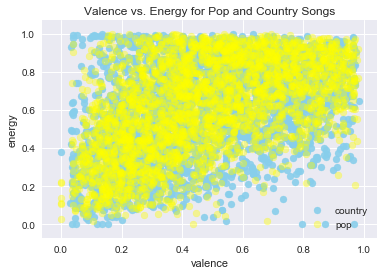

In [12]:
plt.scatter(country['valence'],country['energy'],marker='o',color='skyblue',label='country',alpha=0.9)
plt.scatter(pop['valence'],pop['energy'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('valence')
plt.ylabel('energy')
plt.title('Valence vs. Energy for Pop and Country Songs')
plt.legend()
plt.show()

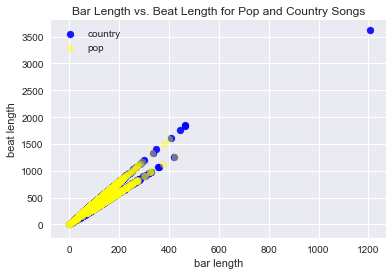

In [13]:
plt.scatter(country['bar_len'],country['beat_len'],marker='o',color='blue',label='country',alpha=0.9)
plt.scatter(pop['bar_len'],pop['beat_len'],marker='o',color='yellow', label='pop',alpha=0.4)
plt.xlabel('bar length')
plt.ylabel('beat length')
plt.title('Bar Length vs. Beat Length for Pop and Country Songs')
plt.legend()
plt.show()

#### The bar length and beat length are similar for the songs tagged as country and pop and not a lot of variation, and will therefore not be used for the analysis.

## Scale the values of the features, and apply PCA for dimensionality reduction.

#### - Scaled Features will be used as input to our Clustering algorithms
#### - PCA output will be used for visualization

The [clustering notebook](https://github.com/ayeshavm/SongFeatures_Unsupervised/blob/master/notebooks/02_SongsFeaturesAnalysis_Clustering_Compare.ipynb),has all the clustering results for the different parameters and clustering methods performed i.e. 
     - KMeans 
     - Agglomerative Clustering Linkage='complete'
     - Agglomerative Clustering Linkage='ward'
     
Other clustering analysis done:
- [Clustering with the generated Flesch-Kincaid Grade](https://github.com/ayeshavm/SongFeatures_Unsupervised/blob/master/notebooks/02_SongsFeaturesAnalysis_Clustering_Compare.ipynb) (Lyrics Readability Grade)
- [Clustering with 10 features](https://github.com/ayeshavm/SongFeatures_Unsupervised/blob/master/notebooks/02_SongsFeaturesAnalysis_Clustering_n10Features.ipynb)

KMeans clustering where k=3 appears to give the more distinct segregation between the three clusters, and
the clusters/values do not change significantly when more features were added.
 
The following sections in this notebook will go over the results for the KMeans clustering where K=3, with n=6 (six features).  
 
The features where we found some correlation were selected to be used for further analysis:
- pitch+timbre - positive correlation
- valence+danceability - positive correlation
- energy+acousticness - negative correlation (high energy - low acoustic)
- energy+pitch - positive correlation

In [14]:
## Scale features before applying PCA.  Features in our dataframe our not standardized, we have some features which 
## are normalized, and some which are not.

from sklearn.preprocessing import StandardScaler


features = ['danceability', 'energy', 'acousticness', 'valence', 'pitch_med',  'timbre_med']

In [15]:
x = songsDF.loc[:, features].values
y = songsDF.loc[:, 'genre'].values

In [16]:
x = StandardScaler().fit_transform(x)

In [17]:
Xtr = x.copy()   #Xtr will be scaled values

In [18]:
from sklearn.decomposition import PCA

#### Determine number of components for PCA

In [19]:
pca = PCA(n_components=None).fit(x)
components = pca.components_
ex_var = pca.explained_variance_ratio_

In [20]:
sums = ex_var.cumsum()
n_comps = 0
for i, s in enumerate(sums):
    if s > 0.9:
        n_comps = i
        break

In [21]:
n_comps

3

In [22]:
comp_range = range(pca.n_components_)

In [23]:
import numpy as np

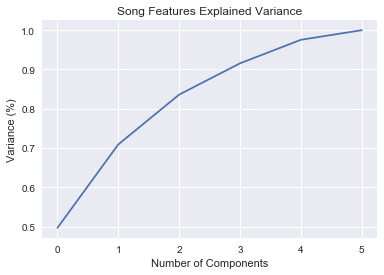

In [24]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Song Features Explained Variance')
plt.show()

In [25]:
data_scaled = pd.DataFrame(Xtr, columns = features)

In [26]:
# transform dataset using n_comps = 3
pca = PCA(n_components=3).fit(Xtr)
x = pca.transform(Xtr)

In [27]:
pca3 = pd.DataFrame(pca.components_, columns=data_scaled.columns, index=['PC-1','PC-2','PC-3']).T
pca3

PC-1      PC-2      PC-3
danceability -0.164489 -0.766859 -0.211481
energy       -0.522465  0.244085 -0.135654
acousticness  0.445688 -0.268657  0.298748
valence      -0.393544 -0.475016 -0.117408
pitch_med    -0.485263  0.208217 -0.038967
timbre_med   -0.333135 -0.105732  0.912316

### Perform clustering on scaled features Xtr

determine the optimum value of K for clustering

In [28]:
from sklearn.cluster import KMeans

In [29]:
def test(data, nClusterRange):
    inertias = np.zeros(len(nClusterRange))
    for i in range(len(nClusterRange)):
        model = KMeans(n_clusters=i+1, init='k-means++').fit(data)
        inertias[i] = model.inertia_
    return inertias

In [30]:
import numpy as np
kRange = range(1,12)
KmeanTopics = test(Xtr, kRange)

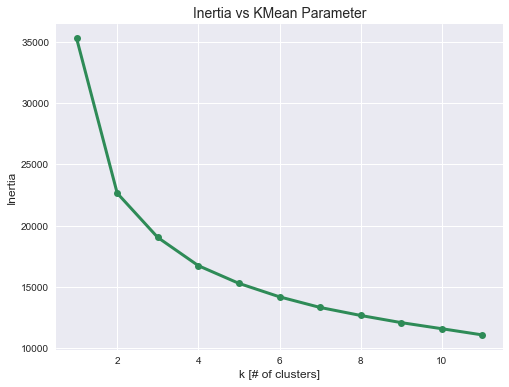

In [31]:
figInertiaWithK = plt.figure(figsize=(8,6))

plt.plot(kRange, KmeanTopics, 'o-', color='seagreen', linewidth=3)
plt.xlabel('k [# of clusters]', size=12)
plt.ylabel('Inertia', size=12)
plt.title('Inertia vs KMean Parameter', size=14)



Let us apply KMeans clustering algorithms using the transformed features and see what patterns/clusters this gives us. 

## KMeans clustering (K = 3) using Scaled features Xtr

In [32]:
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n3'] = cluster_labels

In [33]:
songsDF['pca1'] = x[:,0]
songsDF['pca2'] = x[:,1]
songsDF['pca3'] = x[:,2]


In [34]:
c1 = songsDF[songsDF.K_cluster_n3 == 0]
c2 = songsDF[songsDF.K_cluster_n3 == 1]
c3 = songsDF[songsDF.K_cluster_n3 == 2]


### Plotting first 3 components from transformed dataset to visualize the resulting clusters

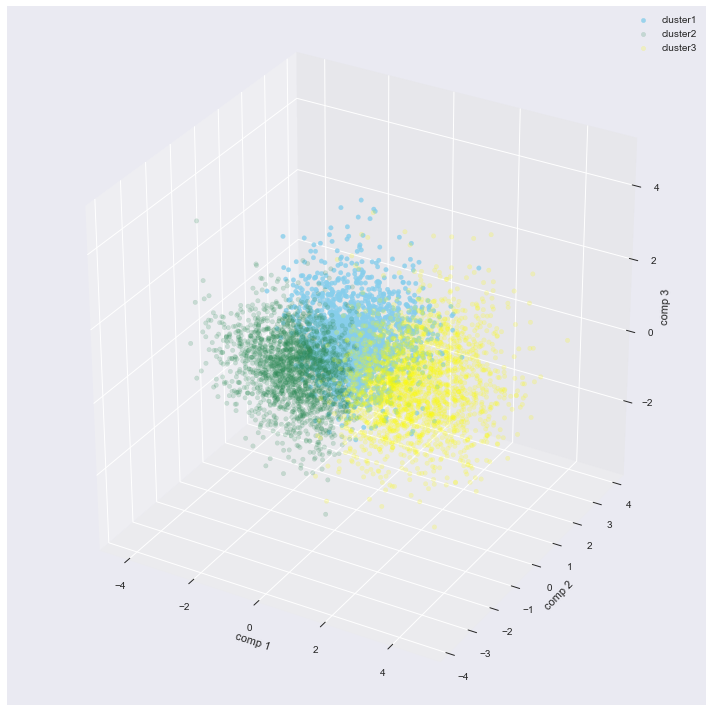

In [35]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(c1['pca1'], c1['pca2'], c1['pca3'], color='skyblue', alpha=0.8, label='cluster1')
p = ax.scatter(c2['pca1'], c2['pca2'], c2['pca3'], color='seagreen', alpha=0.2, label='cluster2')
p = ax.scatter(c3['pca1'], c3['pca2'], c3['pca3'], color='yellow', alpha=0.2, label='cluster3')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_N6.png')


Plotting the same PCA components below colored by the tagged genre of the songs (pop vs country), we will notice the overlapping feature values between the two genres.

In [36]:
country = songsDF[songsDF.genre == 'country']
pop     = songsDF[songsDF.genre == 'pop']

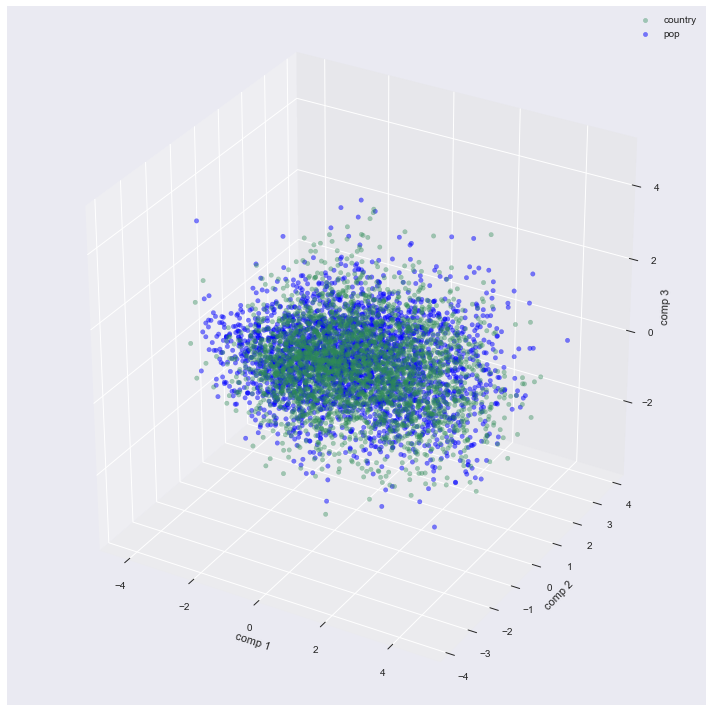

In [37]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig3d = plt.figure(figsize=(10, 10))
ax = fig3d.add_subplot(111, projection='3d')

p = ax.scatter(country['pca1'], country['pca2'], country['pca3'], color='seagreen', alpha=0.4, label='country')
p = ax.scatter(pop['pca1'], pop['pca2'], pop['pca3'], color='blue', alpha=0.5, label='pop')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')

ax.legend()
fig3d.tight_layout()
plt.savefig('../images/KMeans3D_PCA1_3_CountryPop.png')


## Let us look deeper into the resulting cluster features, to see how our KMeans clustering broke down our clusters:

Scale the timbre_med column so that all features are in 0-1 range for the spider plot.

In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
songsDF['timbre_med_scaled'] = scaler.fit_transform(songsDF[['timbre_med']])

In [39]:
def clustSummary(col, k):
    clust_summ = {'group':[], 'danceability':[], 'energy':[],
                  'acousticness': [], 'valence': [], 'pitch':[], 'timbre':[]}

    for num in range(k):
        clust_summ['group'].append('Cluster{}'.format(num))
        clust_summ['danceability'].append(songsDF[songsDF[col] == num]['danceability'].median())
        clust_summ['energy'].append(songsDF[songsDF[col] == num]['energy'].median())
        clust_summ['acousticness'].append(songsDF[songsDF[col] == num]['acousticness'].median())
        clust_summ['valence'].append(songsDF[songsDF[col] == num]['valence'].median())
        clust_summ['pitch'].append(songsDF[songsDF[col] == num]['pitch_med'].median())
        clust_summ['timbre'].append(songsDF[songsDF[col] == num]['timbre_med_scaled'].median())
        
    return clust_summ;

In [40]:
KM3_clust_df = pd.DataFrame(clustSummary('K_cluster_n3',3))[['group','danceability','energy','acousticness','valence','pitch','timbre']]
KM3_clust_df

group  danceability  energy  acousticness  valence   pitch    timbre
0  Cluster0         0.448   0.786        0.0198    0.398  0.2310  0.420202
1  Cluster1         0.642   0.732        0.1080    0.726  0.2365  0.467765
2  Cluster2         0.517   0.350        0.6730    0.263  0.1315  0.349806

Create Spider plot to visualize the three clusters identified by K-Means

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

In [42]:
def getClusterSummResults(clustLabel, k=3):
    ''' returns a dataframe with summarized results for the clustering method'''
    
    clust_summ = {'cluster':[],'mSong_tag':[],'count':[], 'Pct Overall Genre': []}
    
    total_msong_pop = songsDF[(songsDF.genre == 'pop')].song_id.count()
    total_msong_country = songsDF[(songsDF.genre == 'country')].song_id.count()
    
    for num in range(k):
        clust_count_cntry = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'country')].song_id.count()
        clust_count_pop   = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'pop')].song_id.count()
    
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('country')
        clust_summ['count'].append(clust_count_cntry)
        clust_summ['Pct Overall Genre'].append(clust_count_cntry/total_msong_country*100)
    
        clust_summ['cluster'].append(num)
        clust_summ['mSong_tag'].append('pop')
        clust_summ['count'].append(clust_count_pop)
        clust_summ['Pct Overall Genre'].append(clust_count_pop/total_msong_pop*100)

    
    summDF = pd.DataFrame(clust_summ)
    summDF = summDF[['cluster','mSong_tag','count','Pct Overall Genre']].copy()
    return summDF

In [43]:
def plotClusterSpider(KM_clust_df):
    my_palette = plt.cm.get_cmap("Set2", len(KM_clust_df.index))

    plt.figure(figsize=(20,10))

    for row in range(0, len(KM_clust_df.index)):
    
        categories=list(KM_clust_df)[1:]
        N = len(categories)
        title='group '+KM_clust_df['group'][row]
        color=my_palette(row)
 
        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
    

    
        # Initialise the spider plot
        ax = plt.subplot(1,3,row+1, polar=True, )
        #ax = plt.subplot(110+(row+1), polar=True, )
 
        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
 
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories, color='grey', size=12)
 
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(np.linspace(0,1.0,5), [str(x) for x in np.linspace(0,1.0,5)], color="grey", size=10)
        plt.ylim(0,1)
 
        # Ind1
        values=KM_clust_df.loc[row].drop('group').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
        ax.fill(angles, values, color=color, alpha=0.4)
 
        # Add a title
        plt.title(title, size=11, color=color, y=1.1, fontsize=20)

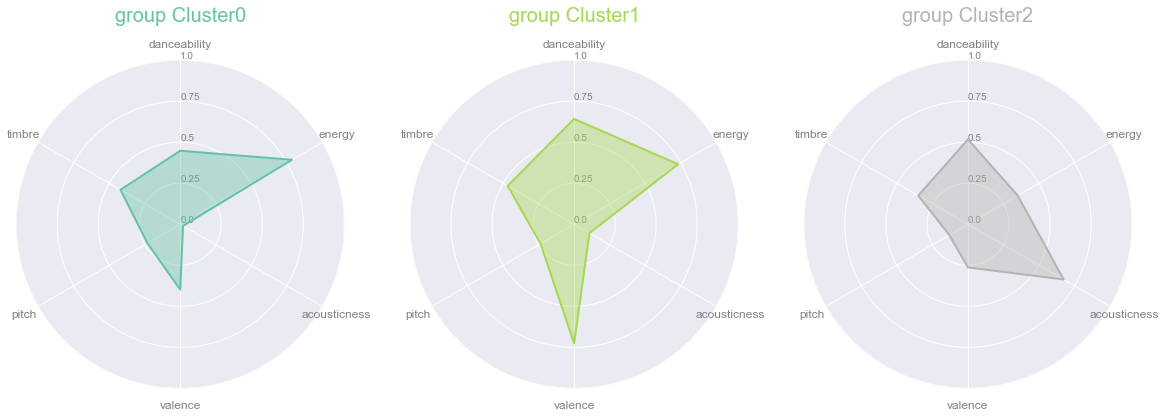

In [44]:
plotClusterSpider(KM3_clust_df)

### Cluster Summary - KMeans (k=3)

#### The three song clusters are broken down into the following features:
<br> __Cluster 0__ - high energy, low valence, low acousticness
<br> __Cluster 1__ - High energy, high danceability, high valence, low acousticness
<br> __Cluster 2__ - high acousticness, low energy, low valence

The main distinguishing features appear to be __Energy__, __Acousticness__, and __valence__.

We can see from how our songs were broken down to these three clusters that there are almost same percentages of country songs and pop songs.  There are a little more pop songs in Clusters 0 and 1 (high energy, low acoustic clusters), and a little more country in cluster 2 (high acoustic cluster).  

In [45]:
KMeansDF3 = getClusterSummResults('K_cluster_n3')
KMeansDF3

cluster mSong_tag  count  Pct Overall Genre
0        0   country    915          29.678884
1        0       pop    894          31.951394
2        1   country   1035          33.571197
3        1       pop    959          34.274482
4        2   country   1133          36.749919
5        2       pop    945          33.774124

Looking at the year the songs were released in the graphs below, both country and pop songs appear to be distributed consistently across all three clusters.

In [46]:
def getbyYearSumm(clustLabel, k=3):
    ''' returns a dataframe with summarized results for the clustering method'''
    
    year_summ = {'cluster':[],'mSong_tag':[],'Year':[], 'count':[], 'Pct Overall Genre': []}
    yearCat = ['1990-1995', '2000-2005', '2006-2010']
    
    total_msong_pop = songsDF[(songsDF.genre == 'pop')].song_id.count()
    total_msong_country = songsDF[(songsDF.genre == 'country')].song_id.count()
    
    for num in range(k):
        for cat in yearCat:
            clust_count_cntry = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'country') &
                                        (songsDF['songYear'] == cat)].song_id.count()
            clust_count_pop   = songsDF[(songsDF[clustLabel] == num) & (songsDF.genre == 'pop') &
                                        (songsDF['songYear'] == cat)].song_id.count()
    
    
            year_summ['cluster'].append(num)
            year_summ['mSong_tag'].append('country')
            year_summ['Year'].append(cat)
            year_summ['count'].append(clust_count_cntry)
            year_summ['Pct Overall Genre'].append(clust_count_cntry/total_msong_country*100)
    
            year_summ['cluster'].append(num)
            year_summ['mSong_tag'].append('pop')
            year_summ['Year'].append(cat)
            year_summ['count'].append(clust_count_pop)
            year_summ['Pct Overall Genre'].append(clust_count_pop/total_msong_pop*100)

    
    summDF = pd.DataFrame(year_summ)
    summDF = summDF[['cluster','mSong_tag','Year','count','Pct Overall Genre']].copy()
    return summDF

In [47]:
df = getbyYearSumm('K_cluster_n3', 3)

We have below the distribution of the song genres across our song Year categories: 1990-1995, 2000-2005, 2006-2010 

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


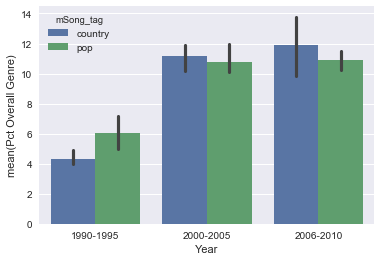

In [48]:
sns.barplot(x="Year", y="Pct Overall Genre", hue="mSong_tag",  data=df);

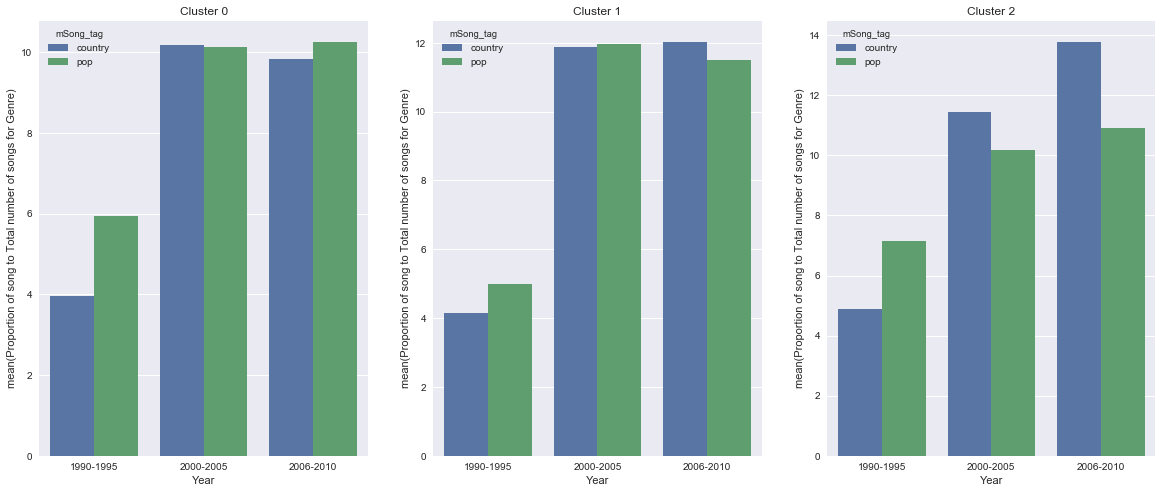

In [49]:
fig = plt.figure(figsize=(20,8))
ax =  plt.subplot(1,3,1)
sns.barplot(x="Year", y="Pct Overall Genre", hue="mSong_tag",  data=df[df.cluster == 0]);
plt.ylabel('mean(Proportion of song to Total number of songs for Genre)')
plt.title('Cluster 0')
ax =  plt.subplot(1,3,2)
sns.barplot(x="Year", y="Pct Overall Genre", hue="mSong_tag",  data=df[df.cluster == 1]);
plt.ylabel('mean(Proportion of song to Total number of songs for Genre)')
plt.title('Cluster 1')
ax =  plt.subplot(1,3,3)
sns.barplot(x="Year", y="Pct Overall Genre", hue="mSong_tag",  data=df[df.cluster == 2]);
plt.ylabel('mean(Proportion of song to Total number of songs for Genre)')
plt.title('Cluster 2')

There doesn't appear to be any significant differences as far how the year of the song affected how it was classified.

### Below are some sample songs which were classified into each of the three clusters.
Artists' songs do not belong to just one classification of song, such as for Beyonce and Keith Urban below. Where we will find their songs classified in all of the three clusters.

###  Cluster 0
[Beyonce Irreplaceable 2006](https://www.youtube.com/watch?v=2EwViQxSJJQ)
<br>[Keith Urban Raining on Sunday 2002 ](https://www.youtube.com/watch?v=DgV7RG9Qgvk)
<br>[Martina McBride So Magical - 2003](https://www.youtube.com/watch?v=sgBqG3bRH7I)
<br>[Celine Dion    Can't Fight the Feeling-2007](https://www.youtube.com/watch?v=88SXDM68fl4)      
<br>[Britney Spears Touch of My Hand 2003](https://www.youtube.com/watch?v=-SnQcYcG41U)
<br>[Billy Currington That's Just Me     2003](https://www.youtube.com/watch?v=SqkmGGii6ZI)
<br>[One Republic   Apologize 2007](https://www.youtube.com/watch?v=ZSM3w1v-A_Y)
<br>[Keith Urban   Raining on Sunday  2002](https://www.youtube.com/watch?v=DgV7RG9Qgvk)


### Cluster 1
[Beyonce Crazy In Love 2003](https://www.youtube.com/watch?v=ViwtNLUqkMY)
<br>[Keith Urban - Somebody Like You 2002](https://www.youtube.com/watch?v=eiBinM-f-Pk)
<br>[Christina Aguilera Ain't No Other Man 2006](https://www.youtube.com/watch?v=8x7Ta89QLo4)
<br>[Whitney Houston I'm Every Woman 1992]
<br>[Justin Bieber Runaway Love 2010] 
<br>[Billy Currington  Ain't What it Used to Be 2003](https://www.youtube.com/watch?v=AgUGUrD5zc4)
<br> [Rascal Flatts     Fast Cars and Freedom  2004](https://www.youtube.com/watch?v=ZsilfOVRX3U)
<br>[Martina McBride   You Ain't Woman Enough 2005](https://www.youtube.com/watch?v=KLoCza6GfXs)


### Cluster 2

[Beyonce Dangerously in Love 2003](https://www.youtube.com/watch?v=wNCQUauSvkg)
<br>[Keith Urban You are Not Alone Tonight 2002](https://www.youtube.com/watch?v=-KkrfwcwPL0)
<br>Christina Aguilera  Walk Away 2002
<br>Beyonce Dangerously in Love  2003
<br>Leona Lewis My Hands 2009
<br>Rascal Flats  Bless the Broken Road 2004
<br>Lady Antebellum  American Honey 2009



In [50]:
#songsDF[(songsDF.genre == 'pop')].groupby(['artist_name','K_cluster_n3'])['year'].value_counts()

In [51]:
#songsDF[(songsDF.artist_id == 'AR95IYB1187FB3FE0B') & (songsDF.K_cluster_n3 == 2)][['title','year']]

### Cluster 0 - high energy, low valence, high pitch, low acoustic

In [52]:
songsDF[songsDF.K_cluster_n3 == 0][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   1809.000000  1809.000000   1809.000000  1809.000000  1809.000000   
mean       0.437602     0.771189      0.080596     0.403753     0.246945   
std        0.112212     0.144555      0.129136     0.164705     0.074600   
min        0.000000     0.000063      0.000002     0.000000     0.095250   
25%        0.366000     0.663000      0.001190     0.280000     0.189250   
50%        0.448000     0.786000      0.019800     0.398000     0.231000   
75%        0.519000     0.894000      0.110000     0.519000     0.298500   
max        0.733000     0.999000      0.989000     0.965000     0.547000   

        timbre_med  
count  1809.000000  
mean      0.293282  
std       2.578910  
min      -8.877000  
25%      -1.359750  
50%       0.250000  
75%       1.920500  
max       9.700500

### Cluster 1 - High energy, high danceability, high valence, high timbre

In [53]:
songsDF[songsDF.K_cluster_n3 == 1][features ].describe() 

danceability       energy  acousticness      valence    pitch_med  \
count   1994.000000  1994.000000   1994.000000  1994.000000  1994.000000   
mean       0.649138     0.716218      0.185554     0.715954     0.240980   
std        0.094640     0.159070      0.205722     0.152384     0.060456   
min        0.321000     0.071100      0.000009     0.178000     0.076500   
25%        0.584250     0.602000      0.025725     0.608000     0.197000   
50%        0.642000     0.732000      0.108000     0.726000     0.236500   
75%        0.708000     0.845000      0.280000     0.838000     0.278875   
max        0.938000     0.999000      0.992000     0.982000     0.477250   

        timbre_med  
count  1994.000000  
mean      1.829209  
std       2.906276  
min      -9.486500  
25%      -0.109438  
50%       1.781000  
75%       3.744500  
max      18.913250

### Cluster 2 - lower energy, high acoustic, lowest valence, low timbre, low pitch

In [54]:
songsDF[songsDF.K_cluster_n3 == 2][features ].describe()  

danceability       energy  acousticness      valence    pitch_med  \
count   2078.000000  2078.000000   2078.000000  2078.000000  2078.000000   
mean       0.499639     0.343905      0.617959     0.292769     0.134932   
std        0.137865     0.139952      0.269359     0.164111     0.040041   
min        0.000000     0.000020      0.000002     0.000000     0.036250   
25%        0.409000     0.244000      0.430250     0.169250     0.106813   
50%        0.517000     0.350000      0.673000     0.263000     0.131500   
75%        0.598000     0.446000      0.844000     0.390750     0.159500   
max        0.883000     0.789000      0.996000     0.966000     0.311750   

        timbre_med  
count  2078.000000  
mean     -2.007828  
std       3.296216  
min     -13.276000  
25%      -4.156937  
50%      -2.016000  
75%       0.066625  
max      13.745000

Below shows the clusters in relation to the features:

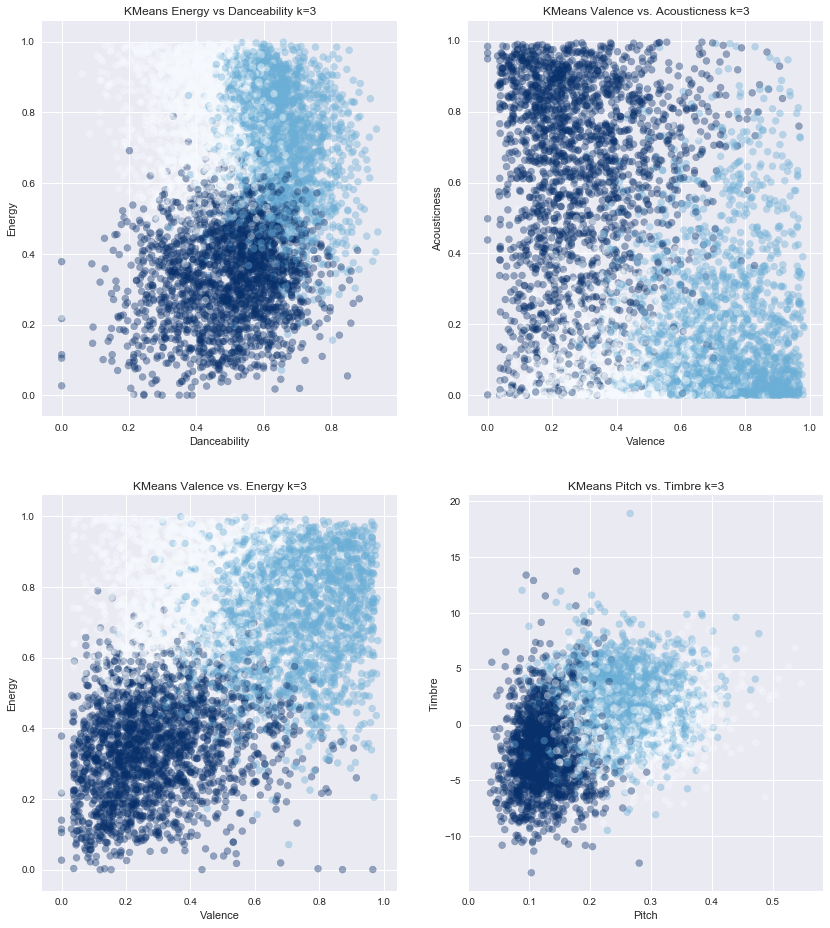

In [55]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n3'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K3.png')

## Let us explore how the clusters will be divided if we just create two clusters (k=2)

In [56]:
km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n2'] = cluster_labels

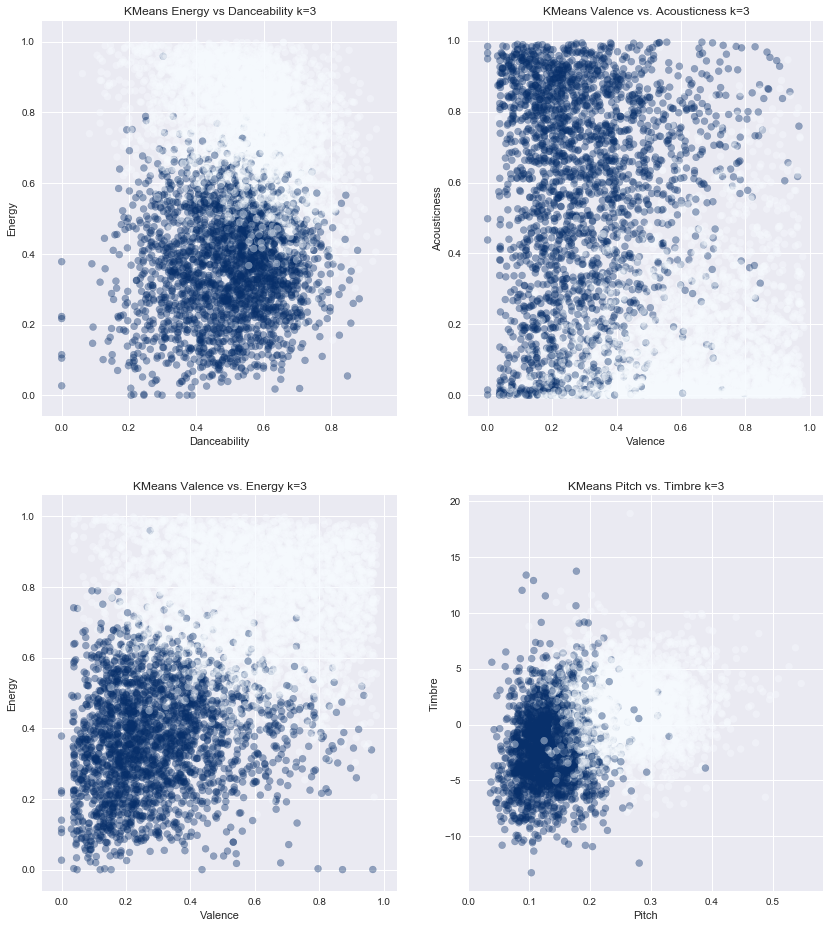

In [57]:
fig = plt.figure(figsize=(14,16))


ax1=plt.subplot(2, 2, 1)
ax1.scatter(songsDF['danceability'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Danceability')
plt.ylabel('Energy')
ax1.set_title('KMeans Energy vs Danceability k=3')


ax2=plt.subplot(2, 2, 2)
ax2.scatter(songsDF['valence'],songsDF['acousticness'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Acousticness')
ax2.set_title('KMeans Valence vs. Acousticness k=3')


ax3=plt.subplot(2, 2, 3)
ax3.scatter(songsDF['valence'],songsDF['energy'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3), )
plt.xlabel('Valence')
plt.ylabel('Energy')
ax3.set_title('KMeans Valence vs. Energy k=3')

ax4=plt.subplot(2, 2, 4)
ax4.scatter(songsDF['pitch_med'],songsDF['timbre_med'],marker='o',c=songsDF['K_cluster_n2'], alpha=0.4,
           cmap=plt.cm.get_cmap('Blues', 3) )
plt.xlabel('Pitch')
plt.ylabel('Timbre')
ax4.set_title('KMeans Pitch vs. Timbre k=3')

plt.savefig('../images/KMeans_FeaturesClusters_K2.png')

In [58]:
KM2_clust_df = pd.DataFrame(clustSummary('K_cluster_n2',2))[['group','danceability','energy','acousticness','valence','pitch','timbre']]
KM2_clust_df

group  danceability  energy  acousticness  valence   pitch    timbre
0  Cluster0         0.566   0.775        0.0516    0.590  0.2405  0.446298
1  Cluster1         0.508   0.371        0.6310    0.266  0.1370  0.356792

Similar to the 3-cluster output, the main distinguishing features appear to be __Energy__, __Acousticness__, and __valence__.

Cluster 0 - has high energy, high valence, and low acousticness,
whereas
<br>Cluster 1 - has high acousticness, low energy, and low valence.

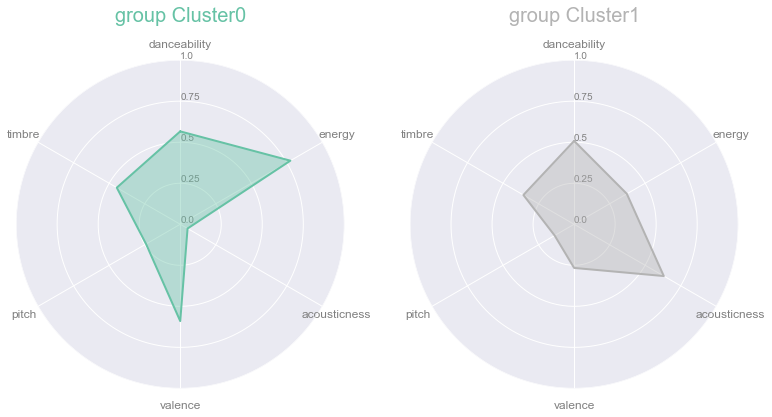

In [59]:
plotClusterSpider(KM2_clust_df)

And checking again how the different (country and pop songs) genres were split into these two clusters, we will still see a huge overlap between the two genres, and that more pop songs are classified as cluster 0 (high energy, low acoustic), and more country songs are classified as Cluster 1 (high acoustic, low energy).

In [60]:
KMeansDF2 = getClusterSummResults('K_cluster_n2',2)
KMeansDF2

cluster mSong_tag  count  Pct Overall Genre
0        0   country   1793          58.157639
1        0       pop   1724          61.615440
2        1   country   1290          41.842361
3        1       pop   1074          38.384560

In [61]:
df = getbyYearSumm('K_cluster_n2', 2)

The song year does not appear to have any impact as well on how the song was classified.

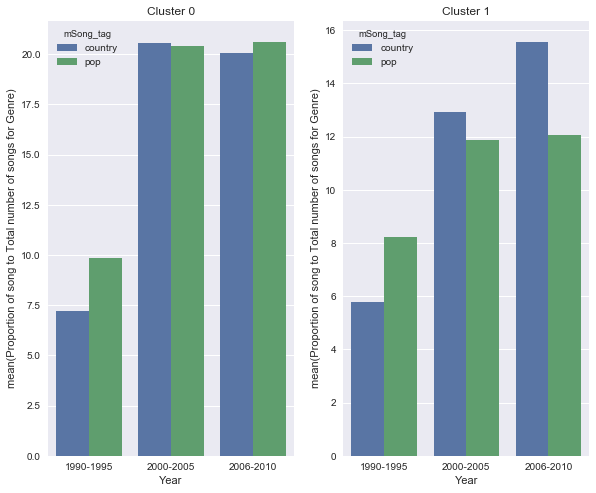

In [62]:
fig = plt.figure(figsize=(15,8))
ax =  plt.subplot(1,3,1)
sns.barplot(x="Year", y="Pct Overall Genre", hue="mSong_tag",  data=df[df.cluster == 0]);
plt.ylabel('mean(Proportion of song to Total number of songs for Genre)')
plt.title('Cluster 0')
ax =  plt.subplot(1,3,2)
sns.barplot(x="Year", y="Pct Overall Genre", hue="mSong_tag",  data=df[df.cluster == 1]);
plt.ylabel('mean(Proportion of song to Total number of songs for Genre)')
plt.title('Cluster 1')

Below are plots showing how sample songs/artists were classified:

In [71]:
def plotClustSongArtist(xcol, ycol, num_songs=50):
    '''plot Song/Artist for each cluster and color by genre
       num_songs: number of songs to plot'''
    Top_songs = songsDF[songsDF.artist_hotttnesss > 0.5].sort_values('song_id', ascending=False).head(num_songs)
    
    clust0 = Top_songs[Top_songs.K_cluster_n2 == 0]
    clust1 = Top_songs[Top_songs.K_cluster_n2 == 1]
    
    fig = plt.figure(figsize=(20,20))
    ax = plt.subplot(1,2,1)
    p1 = sns.regplot(data=clust0[clust0.genre == 'country'] ,x=xcol, y=ycol, fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='Country')
    p1 = sns.regplot(data=clust0[clust0.genre == 'pop'] ,x=xcol, y=ycol, fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='Pop')

    for line in range(0,clust0.shape[0]):
        p1.text(clust0[xcol].iloc[line] + 0.02, clust0[ycol].iloc[line], clust0.artist_name.iloc[line] + '-'+clust0.title.iloc[line] ,
                horizontalalignment='left', size='large',color='black')
    p1.set_xlabel(xcol)
    p1.set_ylabel(ycol)
    plt.legend()
    p1.set_title('Cluster 0 Sample Songs/Artists {} vs {}'.format(xcol,ycol), fontsize=14)
    ax = plt.subplot(1,2,2)
    p2 = sns.regplot(data=clust1[clust1.genre == 'country'] ,x=xcol, y=ycol, fit_reg=False, marker="o", color='seagreen',
                               scatter_kws={'s':300, 'alpha':0.4},label='Country')
    p2 = sns.regplot(data=clust1[clust1.genre == 'pop'] ,x=xcol, y=ycol, fit_reg=False, marker="o", color='purple',
                               scatter_kws={'s':300, 'alpha':0.4},label='Pop')

    for line in range(0,clust1.shape[0]):
        p2.text(clust1[xcol].iloc[line] + 0.02, clust1[ycol].iloc[line], clust1.artist_name.iloc[line] + '-'+clust0.title.iloc[line] ,
                horizontalalignment='left', size='large',color='black')
    p2.set_xlabel(xcol)
    p2.set_ylabel(ycol)
    plt.legend()
    p2.set_title('Cluster 1 Sample Songs/Artists {} vs {}'.format(xcol,ycol), fontsize=14)

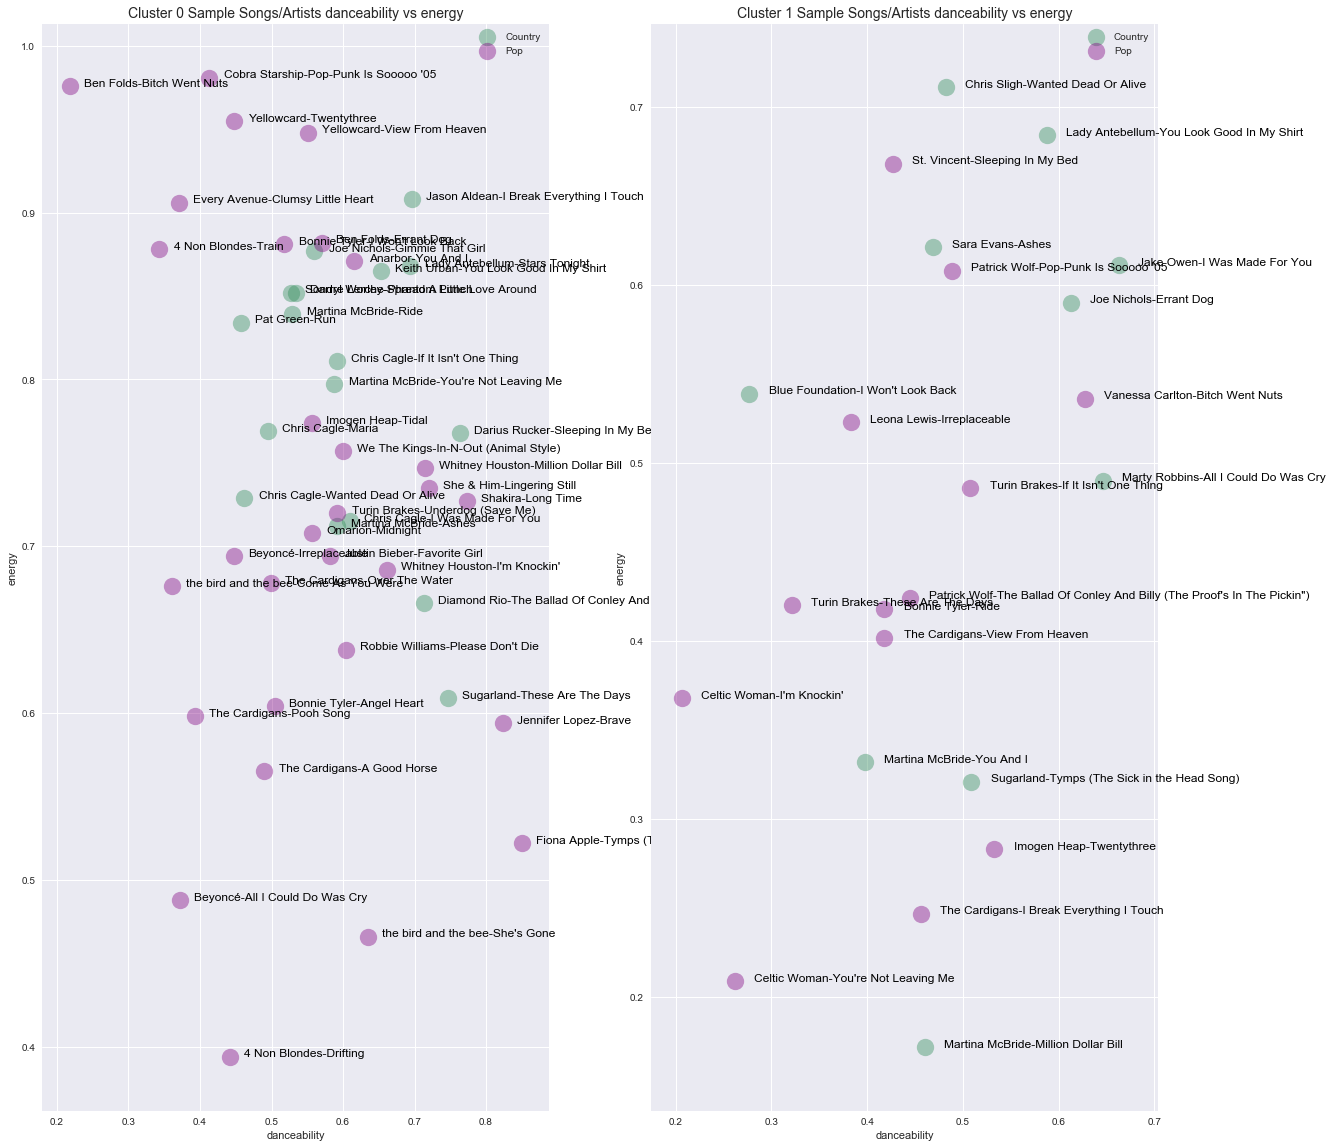

In [72]:
plotClustSongArtist('danceability', 'energy',70)  #update num_songs to change number of songs to plot

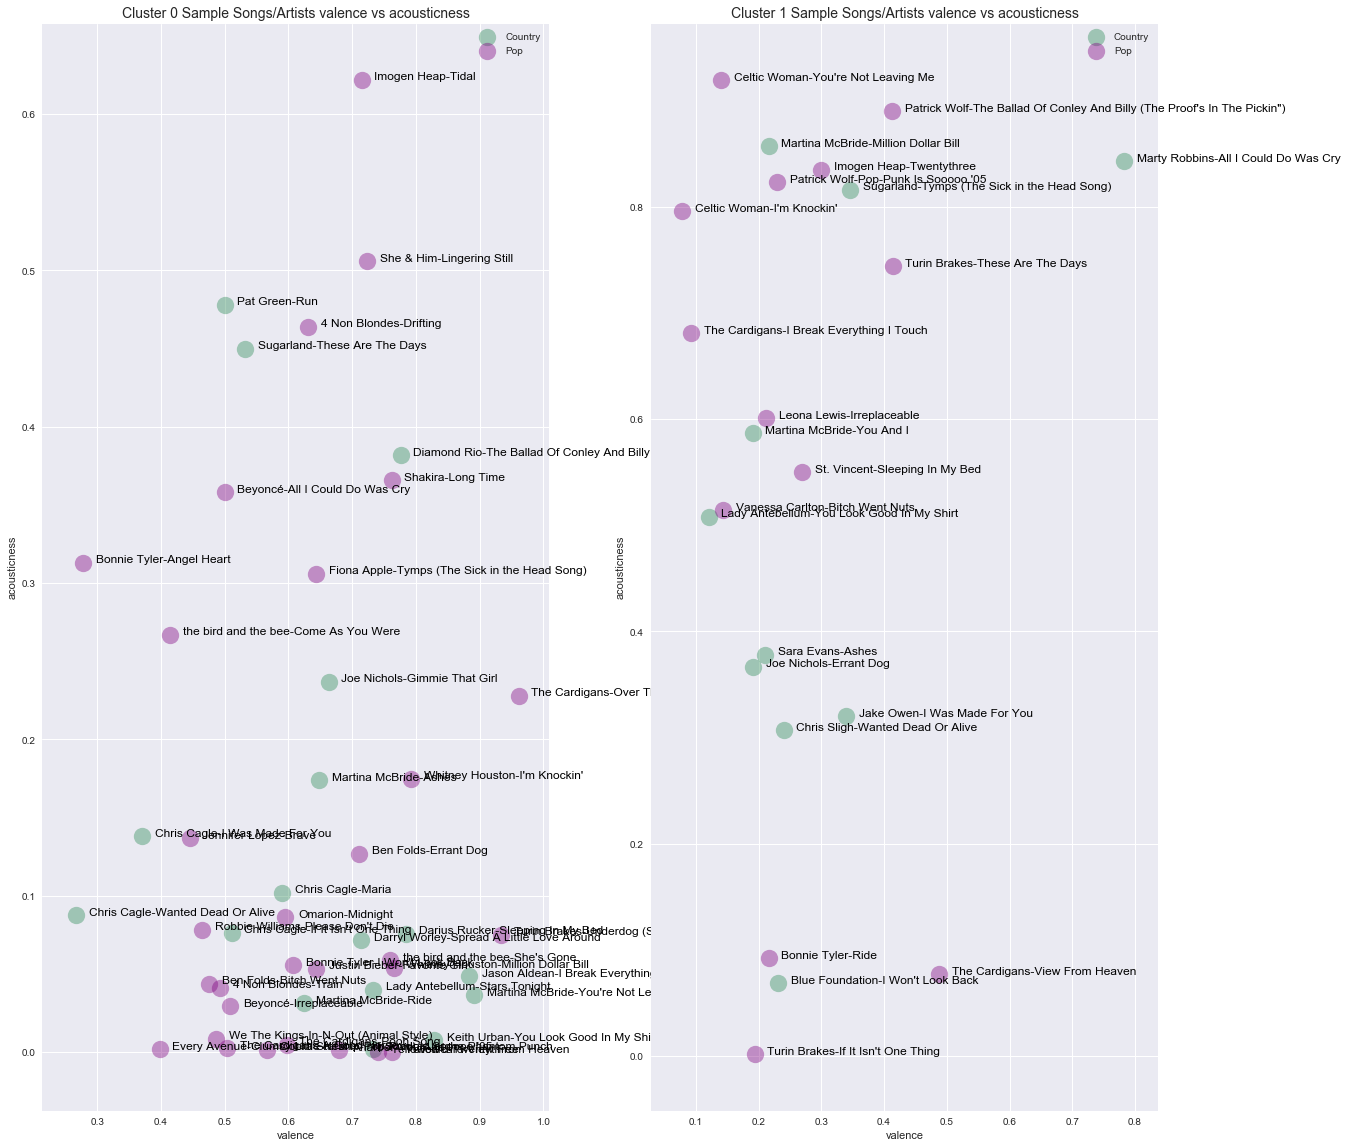

In [73]:
plotClustSongArtist('valence', 'acousticness',70)

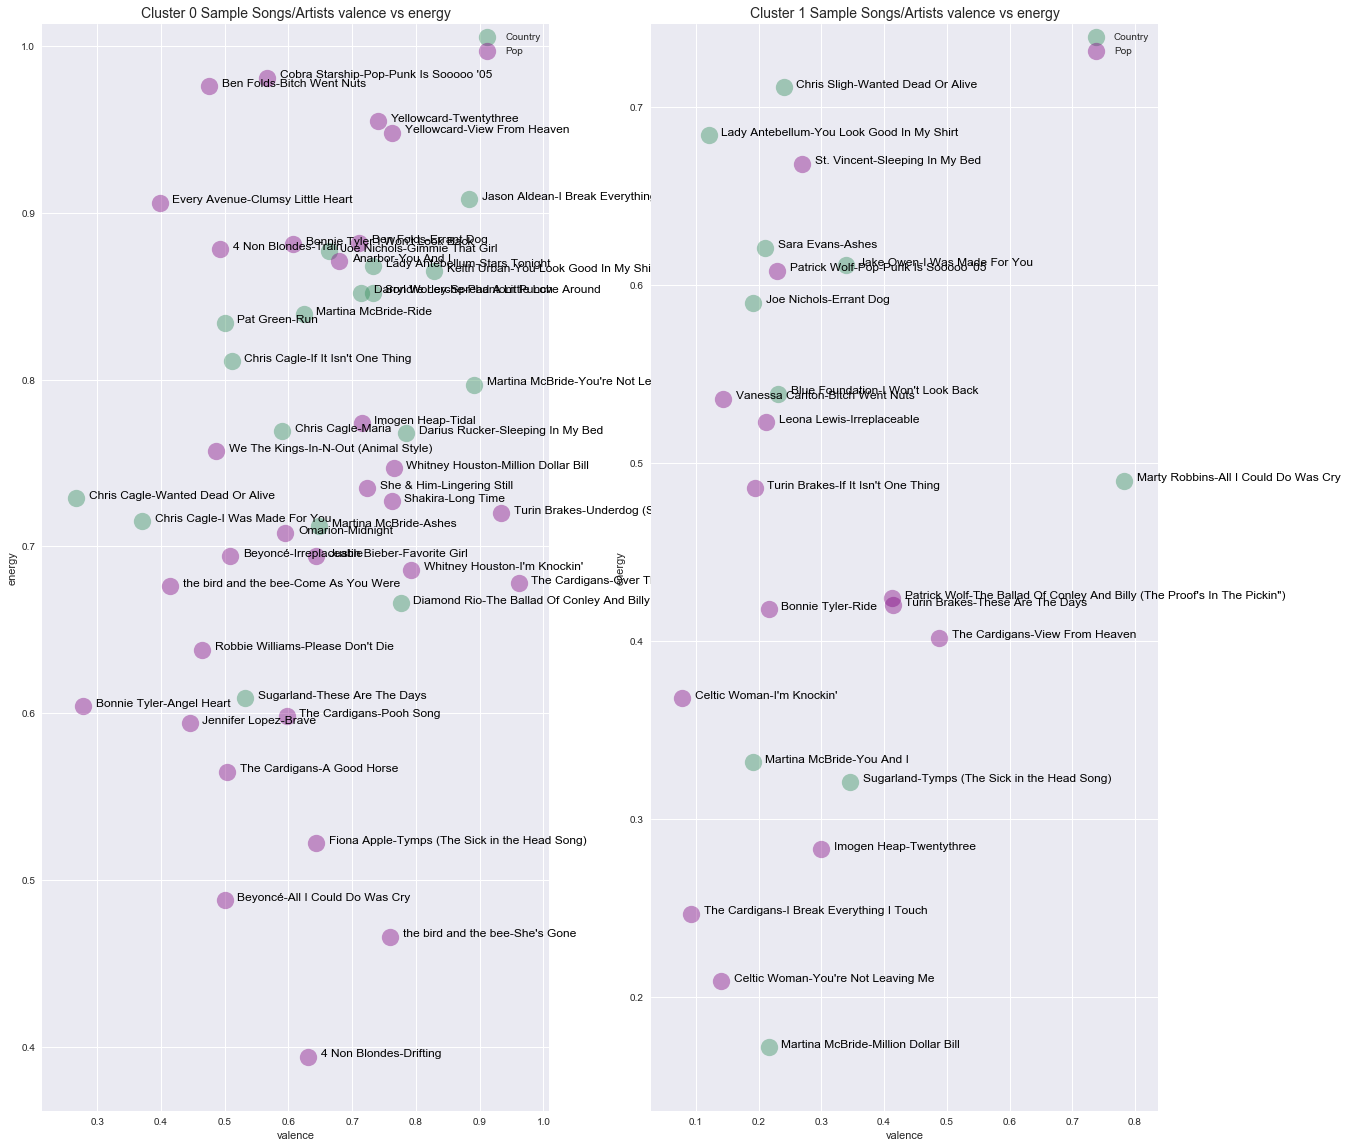

In [74]:
plotClustSongArtist('valence', 'energy',70)

### Findings:

1) The cluster characteristics produced by the three different cluster methods (KMeans, Agglomerative-Ward, Agglomerative-Complete) were similar.  Main clusters can be described with the following features:

- high acousticness, low energy, low valence
- high energy, low valence, low acousticness 
- High energy, high danceability, high valence, low acousticness

2) With the audio features we were able to collect from Spotify, none of these features could clearly distinguish a country song from a Pop song. Although a slightly higher percentage of Country songs are classified under the cluster with (high acoustic, low energy,  low valence), and a slightly higher percentage of Pop songs are classified under the cluster with (high energy, low valence, low acoustic), our results still show a large overlap in values for these features for these two music genres.


# Summary:

### What we have found so far is that we cannot distinguish a country song vs a pop song from the Audio Features:  Acousticness, Danceability, Valence, Energy, Pitch and Timbre.   High Acousticness may just be a more common feature of country song, and High Energy and High Valence for pop songs, but they are not a unique feature for those genres, as we have seen in the large overlap between these two genres in our clusters.   

### These two genres appear to share the same features, other than country songs are sang with a Southern accent perhaps???  -- That is out of scope for this project, and will need an audio analysis - Southern Accent detector for to prove that.


### What was the big deal with [Taylor Swift leaving Country Music in 2014?](https://www.savingcountrymusic.com/taylor-swift-leaving-country-the-deeper-impact/) 

If we look at how her Country songs vs Pop songs were clustered,  we can see that the we have country songs and pop songs clustered together.

In [239]:
from sklearn.preprocessing import StandardScaler

songsDF = pd.read_pickle('../data/TaylorSwiftSongs_input.p')
features = ['danceability', 'energy', 'acousticness', 'valence', 'pitch_med',  'timbre_med']

x = songsDF.loc[:, features].values
y = songsDF.loc[:, 'genre'].values
Xtr = StandardScaler().fit_transform(x)

# transform dataset using n_comps = 2
pca = PCA(n_components=2).fit(Xtr)
pca_out = pca.transform(Xtr)

In [216]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n3'] = cluster_labels

songsDF['pca1'] = x[:,0]
songsDF['pca2'] = x[:,1]

c1 = songsDF[songsDF.K_cluster_n3 == 0]
c2 = songsDF[songsDF.K_cluster_n3 == 1]
c3 = songsDF[songsDF.K_cluster_n3 == 2]

In [234]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
songsDF['timbre_med_scaled'] = scaler.fit_transform(songsDF[['timbre_med']])

In [237]:
KM3_clust_df = pd.DataFrame(clustSummary('K_cluster_n3',3))[['group','danceability','energy','acousticness','valence','pitch','timbre']]
KM2_clust_df = pd.DataFrame(clustSummary('K_cluster_n2',2))[['group','danceability','energy','acousticness','valence','pitch','timbre']]


### Similar cluster features were generated from runningTaylor Swift songs with KMeans clustering for k=3 and k=2

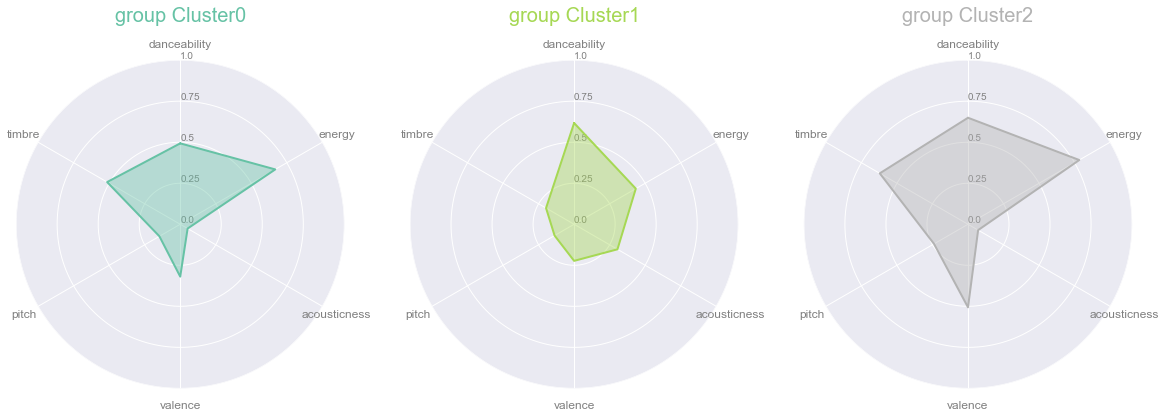

In [236]:
plotClusterSpider(KM3_clust_df)

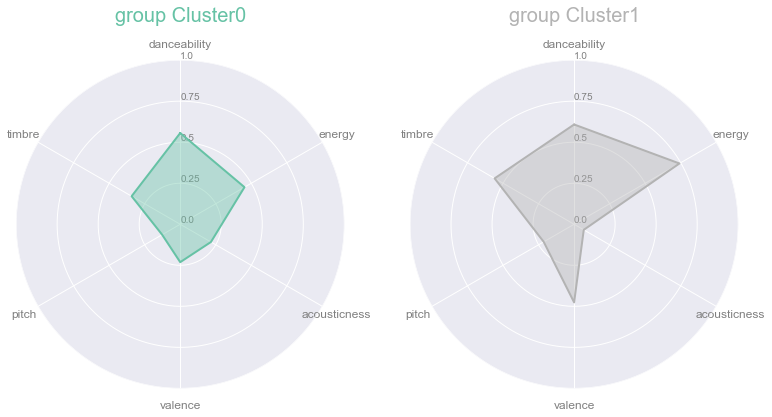

In [238]:
plotClusterSpider(KM2_clust_df)

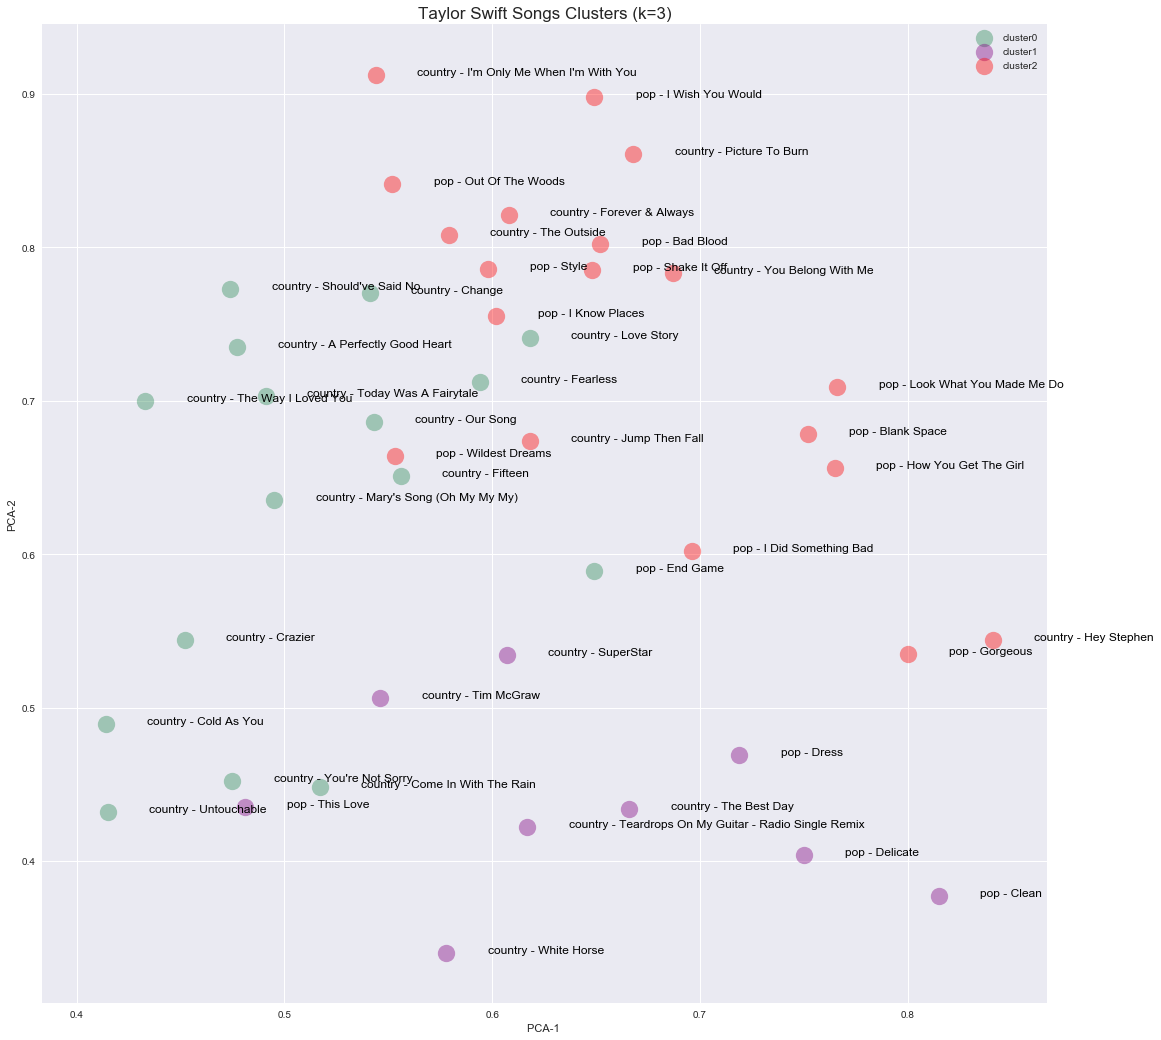

In [231]:
Top_songs = songsDF.copy()
fig = plt.figure(figsize=(18,18))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3 == 0] ,x='pca1', y='pca2', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3 == 1] ,x='pca1', y='pca2', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n3 == 2] ,x='pca1', y='pca2', fit_reg=False, marker="o", color='red',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster2')
for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.danceability.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.genre.iloc[line]+' - ' +Top_songs.title.iloc[line],
            horizontalalignment='left', size='large',color='black')
p1.set_xlabel('PCA-1 ')
p1.set_ylabel('PCA-2')
plt.legend()
p1.set_title('Taylor Swift Songs Clusters (k=3)', fontsize=17)
plt.savefig('../images/Songs_dance_energy_Kmeans.png')

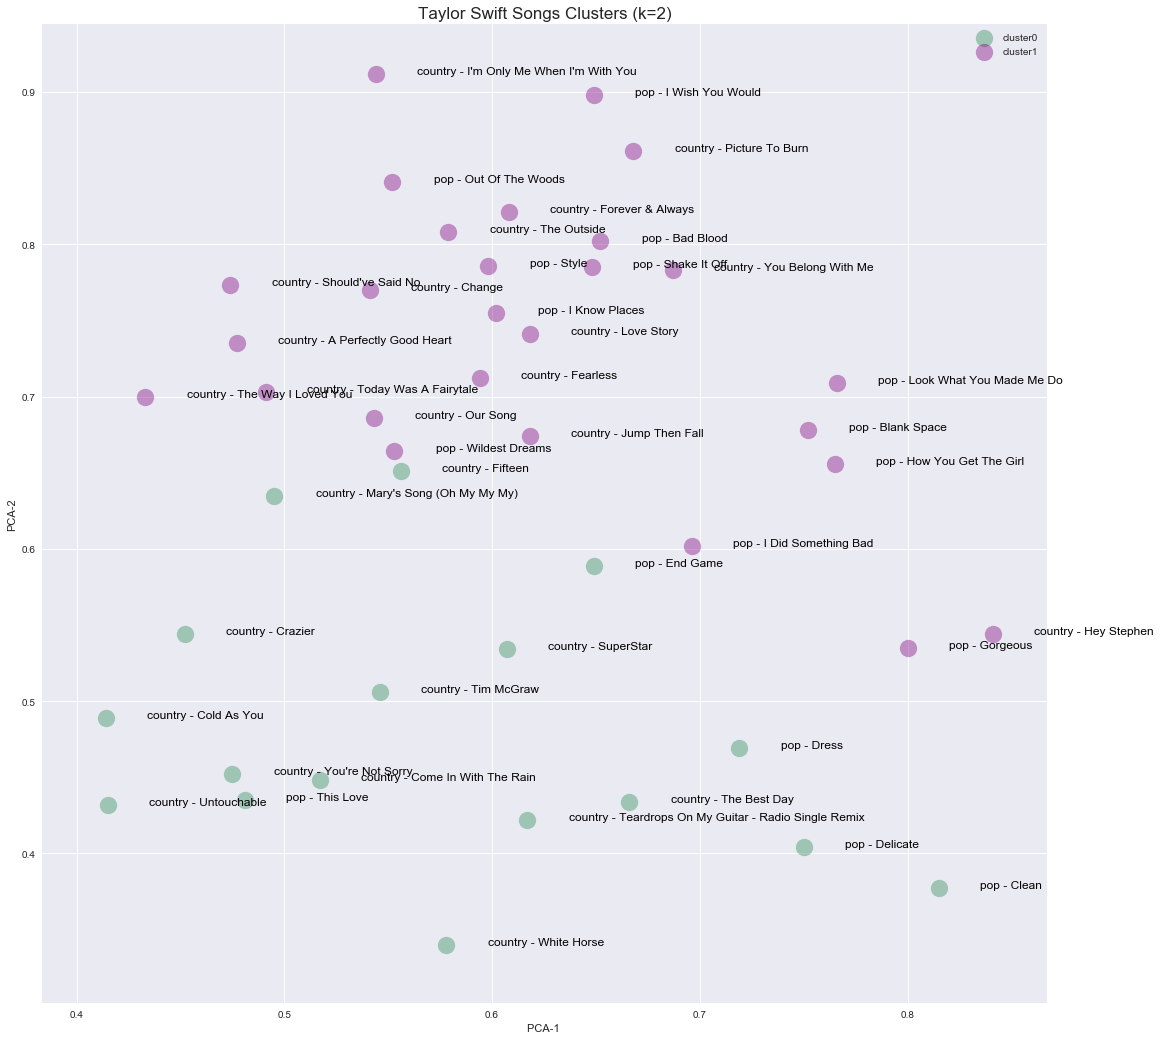

In [232]:
km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(Xtr)
cluster_labels = km.labels_
songsDF['K_cluster_n2'] = cluster_labels

Top_songs = songsDF.copy()
fig = plt.figure(figsize=(18,18))
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 0] ,x='pca1', y='pca2', fit_reg=False, marker="o", color='seagreen',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster0')
p1 = sns.regplot(data=Top_songs[Top_songs.K_cluster_n2 == 1] ,x='pca1', y='pca2', fit_reg=False, marker="o", color='purple',
                           scatter_kws={'s':300, 'alpha':0.4},label='cluster1')

for line in range(0,Top_songs.shape[0]):
    p1.text(Top_songs.danceability.iloc[line] + 0.02, Top_songs.energy.iloc[line], Top_songs.genre.iloc[line]+' - ' +Top_songs.title.iloc[line],
            horizontalalignment='left', size='large',color='black')
p1.set_xlabel('PCA-1 ')
p1.set_ylabel('PCA-2')
plt.legend()
p1.set_title('Taylor Swift Songs Clusters (k=2)', fontsize=17)
plt.savefig('../images/Songs_dance_energy_Kmeans.png')

### Sample Songs from the 2 clusters
#### Cluster 0
country [I'm Only Me When I'm With You](https://www.youtube.com/watch?v=AlTfYj7q5gQ)
<br>pop [I wish you would](https://www.youtube.com/watch?v=nY7hI-0hO58)
<br>pop [I Know Places](https://www.youtube.com/watch?v=CPzC7CTtNE4)
<br>country [Fearless](https://www.youtube.com/watch?v=HECGF_dRwdk)

#### Cluster 1
country [Superstar](https://www.youtube.com/watch?v=z9xqAeVRdv0)
<br>pop [Dress](https://www.youtube.com/watch?v=JjdjOZvvucw)
<br>pop [Delicate](https://www.youtube.com/watch?v=-drlH9mAphk)

### From our findings it doesn't seem like the song features we have gathered make the genre, at least for country and pop.  With the current pop and country scene could it be that it is more the people (where they're from, their personality, the culture they associate with) rather than the song that defines the genre now???  What do you think? 